In [1]:
import numpy
from typing import Optional, Tuple, List
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:

MMOrder = namedtuple("MMOrder", ["size", "price"])

In [95]:
class CFMMarketMaker:
    def __init__(
        self,
        initial_price: float = 100,
        price_width_below: float = 0.05,
        price_width_above: float = 0.05,
        margin_usage_at_bound_above: float = 0.8,
        margin_usage_at_bound_below: float = 0.8,
        volume_per_side: float = 10,
        num_levels: int = 25,
        tick_spacing: float = 1,
    ):
        self.base_price = initial_price
        self.upper_price = (1 + price_width_above) * initial_price
        self.lower_price = (1 - price_width_below) * initial_price

        self.base_price_sqrt = initial_price**0.5
        self.upper_price_sqrt = self.upper_price**0.5
        self.lower_price_sqrt = self.lower_price**0.5

        self.lower_liq_factor = 1 / (self.base_price_sqrt - self.lower_price_sqrt)
        self.upper_liq_factor = 1 / (self.upper_price_sqrt - self.base_price_sqrt)

        self.margin_usage_at_bound_above = margin_usage_at_bound_above
        self.margin_usage_at_bound_below = margin_usage_at_bound_below

        self.tick_spacing = tick_spacing
        self.num_levels = num_levels
        self.volume_per_side = volume_per_side

    def initialise(
        self,
        vega,
    ):
        risk_factors = vega.get_risk_factors(self.market_id)
        self.short_factor, self.long_factor = risk_factors.short, risk_factors.long

    def _quantity_for_move(
        self,
        start_price_sqrt,
        end_price_sqrt,
        range_upper_price_sqrt,
        liquidity_factor,
    ) -> Optional[float]:
        if liquidity_factor == 0:
            return None
        start_fut_pos = (
            liquidity_factor
            * (range_upper_price_sqrt - start_price_sqrt)
            / (start_price_sqrt * range_upper_price_sqrt)
        )
        end_fut_pos = (
            liquidity_factor
            * (range_upper_price_sqrt - end_price_sqrt)
            / (end_price_sqrt * range_upper_price_sqrt)
        )

        return abs(start_fut_pos - end_fut_pos)

    def _generate_shape(
        self, bid_price_depth: float, ask_price_depth: float
    ) -> Tuple[List[MMOrder], List[MMOrder]]:
        return self._generate_shape_calcs(
            balance=sum(
                a.balance
                for a in self.vega.get_accounts_from_stream(
                    key_name=self.key_name,
                    wallet_name=self.wallet_name,
                    market_id=self.market_id,
                )
            ),
            average_entry=(
                self.vega.positions_by_market(
                    wallet_name=self.wallet_name,
                    market_id=self.market_id,
                    key_name=self.key_name,
                ).average_entry_price
                if self.current_position != 0
                else 0
            ),
            position=self.current_position,
        )

    def _quote_price(self,
        balance: float,
        average_entry: float,
        position: float,
        volume: float = 0
    ):
        volume_at_upper = (
            self.margin_usage_at_bound_above
            * (balance / self.short_factor)
            / self.upper_price
        )

        volume_at_lower = (
            self.margin_usage_at_bound_below
            * (balance / self.long_factor)
            / self.lower_price
        )

        upper_L = (
            volume_at_upper
            * self.upper_price_sqrt
            * self.base_price_sqrt
            / (self.upper_price_sqrt - self.base_price_sqrt)
        )

        # lower_L = (
        #     self.margin_usage_at_bound_below
        #     * (balance / self.long_factor)
        #     * self.lower_liq_factor
        # )

        lower_L = (
            volume_at_lower
            * self.lower_price_sqrt
            * self.base_price_sqrt
            / (self.base_price_sqrt - self.lower_price_sqrt)
        )

        if position > 0:
            L = lower_L
            lower_bound = self.lower_price_sqrt
            upper_bound = self.base_price_sqrt
            virt_x = abs(position) + L / upper_bound
            virt_y = (L * (upper_bound - lower_bound) - abs(position) * average_entry) + L * lower_bound
        else:
            L = upper_L
            lower_bound = self.base_price_sqrt
            upper_bound = self.upper_price_sqrt
            virt_x = (volume_at_upper + position) + L / upper_bound
            virt_y = (abs(position) * average_entry) + L * lower_bound

        if volume == 0:
            return virt_y / virt_x
        else:
            out = (virt_y * virt_x) / (virt_x - volume) - virt_y
            return out / volume

    def _generate_shape_calcs(
        self,
        balance: float,
        average_entry: float,
        position: float,
    ) -> Tuple[List[MMOrder], List[MMOrder]]:
        volume_at_upper = (
            self.margin_usage_at_bound_above
            * (balance / self.short_factor)
            / self.upper_price
        )

        volume_at_lower = (
            self.margin_usage_at_bound_below
            * (balance / self.long_factor)
            / self.lower_price
        )

        upper_L = (
            volume_at_upper
            * self.upper_price_sqrt
            * self.base_price_sqrt
            / (self.upper_price_sqrt - self.base_price_sqrt)
        )

        # lower_L = (
        #     self.margin_usage_at_bound_below
        #     * (balance / self.long_factor)
        #     * self.lower_liq_factor
        # )

        lower_L = (
            volume_at_lower
            * self.lower_price_sqrt
            * self.base_price_sqrt
            / (self.base_price_sqrt - self.lower_price_sqrt)
        )

        if position > 0:
            L = lower_L
            lower_bound = self.lower_price_sqrt
            upper_bound = self.base_price_sqrt
            virt_x = abs(position) + L / upper_bound
            virt_y = (L * (upper_bound - lower_bound) - abs(position) * average_entry) + L * lower_bound
        else:
            L = upper_L
            lower_bound = self.base_price_sqrt
            upper_bound = self.upper_price_sqrt
            virt_x = (volume_at_upper + position) + L / upper_bound
            virt_y = (abs(position) * average_entry) + L * lower_bound
        if L == 0:
            ref_price = self.base_price
        else:
            ref_price = virt_y / virt_x

        return self._calculate_price_levels(
            ref_price=ref_price,
            balance=balance,
            upper_L=upper_L,
            lower_L=lower_L,
            position=position,
        )

    def _calculate_liq_val(
        self, margin_frac: float, balance: float, risk_factor: float, liq_factor: float
    ) -> float:
        return margin_frac * (balance / risk_factor) * liq_factor

    def _calculate_price_levels(
        self,
        ref_price: float,
        balance: float,
        upper_L: float,
        lower_L: float,
        position: float,
    ) -> Tuple[List[MMOrder], List[MMOrder]]:
        if ref_price == 0:
            ref_price = self.curr_price

        agg_bids = []
        agg_asks = []

        pos = position

        for i in range(1, self.num_levels):
            pre_price_sqrt = (ref_price + (i - 1) * self.tick_spacing) ** 0.5
            price = ref_price + i * self.tick_spacing

            if price > self.upper_price or price < self.lower_price:
                continue

            volume = self._quantity_for_move(
                pre_price_sqrt,
                price**0.5,
                self.upper_price_sqrt if pos < 0 else self.base_price_sqrt,
                upper_L if pos < 0 else lower_L,
            )
            if volume is not None:
                if pos > 0 and pos - volume < 0:
                    volume = pos
                agg_asks.append(MMOrder(volume, price))
                pos -= volume

        pos = position
        for i in range(1, self.num_levels):
            pre_price_sqrt = (ref_price - (i - 1) * self.tick_spacing) ** 0.5
            price = ref_price - i * self.tick_spacing

            if price > self.upper_price or price < self.lower_price:
                continue

            volume = self._quantity_for_move(
                pre_price_sqrt,
                price**0.5,
                self.upper_price_sqrt if pos < 0 else self.base_price_sqrt,
                upper_L if pos < 0 else lower_L,
            )
            if volume is not None:
                if pos < 0 and pos + volume > 0:
                    volume = pos
                agg_bids.append(MMOrder(volume, price))
                pos += volume

        return agg_bids, agg_asks

Price is 2000.0
Position is 164.98654987300097
Mid is 4485.281374238569


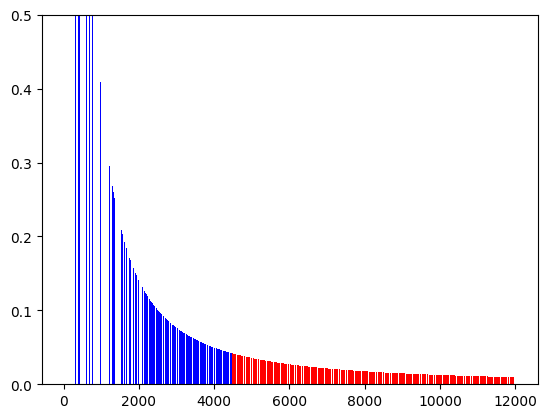

In [71]:

mm = CFMMarketMaker(
    initial_price=2000,
    price_width_above=5,
    price_width_below=0.99,
    margin_usage_at_bound_above=0.8,
    margin_usage_at_bound_below=0.8,
    num_levels=8000,
    tick_spacing=1,
)

balance = 100_000

mm.short_factor = 0.02
mm.long_factor = 0.02

volume_at_upper = (
    mm.margin_usage_at_bound_above * (balance / mm.short_factor) / mm.upper_price
)
volume_at_lower = (
    mm.margin_usage_at_bound_below * (balance / mm.long_factor) / mm.lower_price
)
upper_L = (
    volume_at_upper
    * mm.upper_price_sqrt
    * mm.base_price_sqrt
    / (mm.upper_price_sqrt - mm.base_price_sqrt)
)

lower_L = (
    volume_at_lower
    * mm.base_price_sqrt
    * mm.lower_price_sqrt
    / (mm.base_price_sqrt - mm.lower_price_sqrt)
)

# lower_L = (
#     mm.margin_usage_at_bound_below
#     * (balance / mm.long_factor)
#     * mm.lower_liq_factor
# )

to_price = 4000
pos = mm._quantity_for_move(
    mm.base_price_sqrt,
    to_price**0.5,
    mm.base_price_sqrt if to_price < mm.base_price else mm.upper_price_sqrt,
    lower_L if to_price < mm.base_price else upper_L,
)

print("Price is {}".format(mm._quote_price(
        balance=balance, average_entry=0, position=0
    ))
)

print("Position is {}".format(pos))
bids, asks = mm._generate_shape_calcs(
    balance=balance, average_entry=to_price, position=(-1 if to_price > mm.base_price else 1) * pos
)

# x = []
# y = []

# cumsum = 0
# for bid in bids:
#     x.append(bid.price)
#     cumsum += bid.size
#     y.append(cumsum)

# plt.plot(x, y, color="blue")
x = []
y = []

# cumsum = 0
# for ask in asks:
#     x.append(ask.price)
#     cumsum += ask.size
#     y.append(cumsum)
# plt.plot(x, y, color="red")
# plt.show()

cumsum = 0
for bid in bids:
    x.append(bid.price)
    cumsum += bid.size
    y.append(bid.size)

plt.bar(x, y, color="blue")
x = []
y = []

cumsum = 0
for ask in asks:
    x.append(ask.price)
    cumsum += ask.size
    y.append(ask.size)
plt.ylim((0, 0.5))
plt.bar(x, y, color="red")

print(f"Mid is {(bids[0].price + asks[0].price) / 2 }")
plt.show()



In [5]:

mm = CFMMarketMaker(
    initial_price=2000,
    price_width_above=5,
    price_width_below=0.99,
    margin_usage_at_bound_above=0.8,
    margin_usage_at_bound_below=0.8,
    num_levels=8000,
    tick_spacing=1,
)

balance = 100_000

mm.short_factor = 0.02
mm.long_factor = 0.02

single = mm._quote_price(
        balance=balance, average_entry=0, position=0, volume = 5
)

double = mm._quote_price(
        balance=2 * balance, average_entry=0, position=0, volume = 10
)

print(f"s: {single}, d: {double}")

s: 2017.9115390438587, d: 2017.9115390438587


### Incoming AMM rebaselining

In [126]:
existing_mm = CFMMarketMaker(
    initial_price=2000,
    price_width_above=5,
    price_width_below=0.99,
    margin_usage_at_bound_above=0.8,
    margin_usage_at_bound_below=0.8,
    num_levels=8000,
    tick_spacing=1,
)

incoming_mm = CFMMarketMaker(
    initial_price=1900,
    price_width_above=5,
    price_width_below=0.99,
    margin_usage_at_bound_above=0.8,
    margin_usage_at_bound_below=0.8,
    num_levels=8000,
    tick_spacing=1,
)

balance = 10_000
existing_mm_balance = 10_000

existing_mm.short_factor = 0.02
existing_mm.long_factor = 0.02
incoming_mm.short_factor = 0.02
incoming_mm.long_factor = 0.02

volume_at_upper_incoming = (
    incoming_mm.margin_usage_at_bound_above * (balance / incoming_mm.short_factor) / incoming_mm.upper_price
)
upper_L = (
    volume_at_upper_incoming
    * incoming_mm.upper_price_sqrt
    * incoming_mm.base_price_sqrt
    / (incoming_mm.upper_price_sqrt - incoming_mm.base_price_sqrt)
)


In [128]:
existing_mid = existing_mm._quote_price(existing_mm_balance, 0, 0, 0)

print(f"Mid before is {existing_mid}")

to_rebaseline = incoming_mm._quantity_for_move(incoming_mm.base_price_sqrt, 2000**0.5, incoming_mm.upper_price_sqrt, upper_L)
to_rebaseline_price = incoming_mm._quote_price(balance, 0, 0, to_rebaseline)

print(f"Rebaseline vol is {to_rebaseline} at a price of {to_rebaseline_price}")

existing_quote = existing_mm._quote_price(existing_mm_balance, 0, 0, -1 * to_rebaseline)
new_existing_mid = existing_mm._quote_price(existing_mm_balance, existing_quote, to_rebaseline, 0)
new_new_mid = incoming_mm._quote_price(balance, to_rebaseline_price, -1 * to_rebaseline, 0)

print(f"Now mid for pre-existing is {new_existing_mid} and mid for new is {new_new_mid}")


Mid before is 2000.0000000000002
Rebaseline vol is 1.5013744465623517 at a price of 1949.3588689618002
Now mid for pre-existing is 1997.3344067558412 and mid for new is 2000.0000000000002


In [115]:
90 * 2000 * 0.02

3600.0

In [166]:
starting_pos = 0
px = 2000
start_balance = 1000
balance = 1000
avg_entry = 0
posn = 0

for i in range(1, 31):

    volume_at_upper_incoming = (
        existing_mm.margin_usage_at_bound_above * (balance / existing_mm.short_factor) / existing_mm.upper_price
    )
    upper_L = (
        volume_at_upper_incoming
        * existing_mm.upper_price_sqrt
        * existing_mm.base_price_sqrt
        / (existing_mm.upper_price_sqrt - existing_mm.base_price_sqrt)
    )
    to_rebaseline = existing_mm._quantity_for_move(px**0.5, (px+1)**0.5, existing_mm.upper_price_sqrt, upper_L)
    to_rebaseline_price = existing_mm._quote_price(balance, avg_entry, posn, to_rebaseline)
    px += 1

    balance += posn

    avg_entry = (avg_entry * abs(posn) + abs(to_rebaseline) * to_rebaseline_price) / (abs(posn) + abs(to_rebaseline))
    posn -= to_rebaseline
    print(f"from {px - 1} to {px} takes volume {to_rebaseline} at price {to_rebaseline_price} with posn {posn} and avg entry {avg_entry} and balance {balance}")

step_size = 0.5
for i in range(1, 64):

    volume_at_upper_incoming = (
        existing_mm.margin_usage_at_bound_above * (balance / existing_mm.short_factor) / existing_mm.upper_price
    )
    upper_L = (
        volume_at_upper_incoming
        * existing_mm.upper_price_sqrt
        * existing_mm.base_price_sqrt
        / (existing_mm.upper_price_sqrt - existing_mm.base_price_sqrt)
    )
    to_rebaseline = existing_mm._quantity_for_move(px**0.5, (px-step_size)**0.5, existing_mm.upper_price_sqrt, upper_L)
    to_rebaseline_price = existing_mm._quote_price(balance, avg_entry, posn, -1 * to_rebaseline)
    px -= step_size
    balance -= posn * step_size

    avg_entry = (avg_entry * abs(posn) + abs(to_rebaseline) * to_rebaseline_price) / (abs(posn) + abs(to_rebaseline))
    posn += to_rebaseline
    print(f"from {px + step_size} to {px} takes volume {to_rebaseline} at price {to_rebaseline_price} with posn {posn} and avg entry {avg_entry} and balance {balance}")


from 2000 to 2001 takes volume 0.001407720417296865 at price 2000.4999375147956 with posn -0.001407720417296865 and avg entry 2000.4999375147956 and balance 1000
from 2001 to 2002 takes volume 0.0014066655499660463 at price 2001.4999375473744 with posn -0.0028143859672629112 and avg entry 2000.9997501247774 and balance 999.9985922795827
from 2002 to 2003 takes volume 0.0014056100206993882 at price 2002.499940394373 with posn -0.0042199959879622995 and avg entry 2001.4994383903384 and balance 999.9957778936155
from 2003 to 2004 takes volume 0.0014045538331233232 at price 2003.499948882051 with posn -0.005624549821085623 and avg entry 2001.9990027588153 and balance 999.9915578976276
from 2004 to 2005 takes volume 0.001403496990851849 at price 2004.4999658253962 with posn -0.007028046811937472 and avg entry 2002.4984436749196 and balance 999.9859333478065
from 2005 to 2006 takes volume 0.0014024394974962995 at price 2005.4999940465925 with posn -0.008430486309433771 and avg entry 2002.997

In [143]:
(2000.4999 * abs(-0.001407720417296865) + 0.0014066655499660463 * 2001.4999375473744) / (abs(-0.001407720417296865) + 0.0014)

2005.7501201844145